In [1]:
import cv2
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import signal
from scipy.signal import convolve2d
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the training and testing images from the dataset
train_imgs = [cv2.imread(file) for file in sorted(glob.glob('CASIA Iris Image Database (version 1.0)/*/1/*.bmp'))]
test_imgs = [cv2.imread(file) for file in sorted(glob.glob('CASIA Iris Image Database (version 1.0)/*/2/*.bmp'))]

# Split the images into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_imgs, np.ones((len(train_imgs), 1)), test_size=0.2, random_state=42)

# Define the localization, normalization, enhancement, and feature extraction functions
def localize(img):
    # Perform edge detection using Canny algorithm
    #edges = canny(img, sigma=1, threshold=(100, 200))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200, apertureSize=3)
    return edges

def normalize(edges):
    # Calculate the gradient magnitude and direction at each pixel
    #grad_mag, grad_dir = cv2.gradient(edges, dx=1, dy=1, ksize=3)
    grad_mag = cv2.Sobel(edges, cv2.CV_8U, 1, 0, ksize=3)
    return grad_mag

def enhance(grad_mag):
    # Apply histogram equalization to improve contrast
    equaled_hist = cv2.equalizeHist(grad_mag)
    return equaled_hist

def extract_features(equaled_hist):
    # Calculate the statistical features such as mean, variance, skewness, etc.
    features = []
    for i in range(107):
        features.append(np.mean(equaled_hist[:, i]))
    return np.array(features)

# Apply the functions to the training and validation images
X_train_localized = [localize(img) for img in X_train]
X_val_localized = [localize(img) for img in X_val]
X_train_normalized = [normalize(img) for img in X_train_localized]
X_val_normalized = [normalize(img) for img in X_val_localized]
X_train_enhanced = [enhance(img) for img in X_train_normalized]
X_val_enhanced = [enhance(img) for img in X_val_normalized]
X_train_features = [extract_features(img) for img in X_train_enhanced]
X_val_features = [extract_features(img) for img in X_val_enhanced]

# Create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train_features, y_train)

# Evaluate the model on the validation data
y_pred = model.predict(X_val_features)
conf_mat = confusion_matrix(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
#accuracy, precision, recall, f1 = accuracy_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Print the evaluation metrics
print("Confusion Matrix:\n", conf_mat)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Confusion Matrix:
 [[65]]
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000


In [3]:
def enhance_images(normalized):
    """
    function called enhance_images() that takes an image path as input and returns an enhanced version of the image
    """

    enhanced=[]
    for result in normalized:
        result = result.astype(np.uint8)
        img = cv2.equalizeHist(result)
        enhanced.append(img)
    return enhanced

In [4]:
def localize_iris(images):
    """
    function called localize_iris() that takes an enhanced image as input and returns the location of the iris in the image.
    """

    # Convert image to grayscale
    gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

    # Initialize empty lists to store boundaries and centers
    boundaries = []
    centers = []

    for gray_image in gray_images:
        # Remove noise by bilateral filtering
        filtered_image = cv2.bilateralFilter(gray_image, 9, 75, 75)
        img = filtered_image
        
        # Estimate center of pupil
        center_x = np.mean(filtered_image, 0).argmin()
        center_y = np.mean(filtered_image, 1).argmin()
        
        #recalculate of pupil by concentrating on a 120X120 area
        centered_cropped_image_x = filtered_image[center_x - 60:center_x + 60]
        centered_cropped_image_y = filtered_image[center_y - 60:center_y + 60]
        new_center_x = np.mean(centered_cropped_image_x, 0).argmin()
        new_center_y = np.mean(centered_cropped_image_y, 0).argmin()

        # Draw circle around pupil center
        drawing_image = filtered_image.copy()
        cv2.circle(drawing_image, (new_center_x, new_center_y), 1, (255, 0, 0), 2)

        # Apply Canny edge detection on masked image
        masked_image = cv2.inRange(filtered_image, 0, 70)
        output_image = cv2.bitwise_and(filtered_image, masked_image)
        edges = cv2.Canny(output_image, 100, 220)

        # Find potential boundaries of pupil using Hough Circles
        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 10, 100)

        # Define center of pupil
        pupil_center = (new_center_x, new_center_y)

        # Find circle whose center is closest to approximated center
        min_distance = math.inf
        for circle in circles[0]:
            circle_center = (circle[0], circle[1])
            dist = distance.euclidean(pupil_center, circle_center)
            if dist < min_distance:
                min_distance = dist
                best_circle = circle

        # Draw inner and outer boundaries
        cv2.circle(filtered_image, (int(best_circle[0]), int(best_circle[1])), int(best_circle[2]), (255, 0, 0), 3)
        cv2.circle(filtered_image, (int(best_circle[0]), int(best_circle[1])), int(best_circle[2]) + 53, (255, 0, 0), 3)

        # Append boundaries and centers to respective lists
        boundaries.append(filtered_image)
        centers.append((best_circle[0], best_circle[1], best_circle[2]))

    return boundaries, centers

In [5]:
def dimensionality_reduction(training_data, test_data, num_components):
    """
    Perform dimensionality reduction on the given data using Latent Dirichlet Allocation (LDA).
    """
    # Training data
    X_train = training_data

    y_train = []
    for a in range(0,108):
        for b in range(0,3):
            y_train.append(a+1)
    y_train = np.array(y_train)
    
    # Fit LDA model on training data
    lda = LDA(n_components=num_components)
    lda.fit(X_train, y_train)
    
    # Transform training data
    X_train_reduced = lda.transform(X_train)
    
    # Testing data
    X_test = test_data
    
    # Transform testing data
    X_test_reduced = lda.transform(X_test)
    
    # Predict classes for testing data
    y_pred = lda.predict(X_test)
    
    #return transformed training and testing data, and the testing classes and predicted values for ROC
    return X_train_reduced, X_test_reduced

In [6]:
def matching_iris(train_features, test_features, components, flag):
    """
    Performs matching between train and test sets using dist_L1, dist_L2, and dist_cosine distances.
    """

    #Dimensionality reduction If flag is 1, we don't need to reduce dimensionality, otherwise, we call the dimensionality_reduction function
    if flag == 1:
        reduced_train = train_features
        reduced_test = test_features
        
    elif flag == 0:
        reduced_train, reduced_test = dimensionality_reduction(train_features, test_features, components)


    x_1 = reduced_test
    x_2 = reduced_train

    # Initialize empty lists to store the matching results
    new_cosine = []
    ind_cosine = []
    ind_L1 = []
    ind_L2 = []
    
    # Loop over each test image
    for a in range(0, len(x_1)):
        # Calculate L1, L2, and cosine distances between the test image and each train image
        dist_L1 = []
        dist_L2 = []
        dist_cosine = []
        
        # All training image ompared to each test image
        for b in range(0, len(x_2)):
            testing_data = x_1[a]
            training_data = x_2[b]
            sum_L1 = 0
            sum_L2 = 0
            sum_cos1 = 0
            sum_cos2 = 0
            cosine_dist=0
            
            # Calculate L1, L2 distances and sum of squares of all features
            for c in range(0, len(testing_data)):
                sum_L1 += abs(testing_data[c] - training_data[c])
                sum_L2 += math.pow((testing_data[c] - training_data[c]), 2)
            
            for d in range(0, len(testing_data)):
                sum_cos1 += math.pow(testing_data[d], 2)
                sum_cos2 += math.pow(training_data[d], 2)
                
            
            # Calculate cosine distance using sum_cos1 and sum_cos2 calculated above
            cosine_dist = 1 - ((np.matmul(np.transpose(testing_data), training_data)) / (math.pow(sum_cos1, 0.5) * math.pow(sum_cos2, 0.5)))
            
            dist_cosine.append(cosine_dist)
            dist_L1.append(sum_L1)
            dist_L2.append(sum_L2)

        # Get the indices of the closest matches for each distance metric
        new_cosine.append(min(dist_cosine))
        ind_cosine.append(dist_cosine.index(min(dist_cosine)))
        ind_L1.append(dist_L1.index(min(dist_L1)))
        ind_L2.append(dist_L2.index(min(dist_L2)))
        

    # Store final matching results
    matching_cosine = []
    matching_cosine_ROC = []
    matching_L1 = []
    matching_L2 = []
    
    # Calculate matching according to ROC thresholds
    threshold = [0.4,0.5,0.6]
    count = 0
    match = 0
    
    for m in range(0, len(threshold)):
        matching_ROC = []
        for n in range(0, len(new_cosine)):
            if new_cosine[n] <= threshold[m]:
                matching_ROC.append(1)
            else:
                matching_ROC.append(0)
        matching_cosine_ROC.append(matching_ROC)
        
    # Iterate through test set and update matching arrays
    for o in range(0, len(ind_L1)):
        if count < 4:
            count += 1
        else:
            match += 3
            count = 1
            
        if ind_L1[o] in range(match, match+3):
                matching_L1.append(1)
        else:
            matching_L1.append(0)
        
        if ind_L2[o] in range(match, match+3):
            matching_L2.append(1)
        else:
            matching_L2.append(0)
        
        if ind_cosine[o] in range(match, match+3):
            matching_cosine.append(1)
        else:
            matching_cosine.append(0)
    
    return matching_L1,matching_L2,matching_cosine,matching_cosine_ROC

In [7]:
def normalize_iris(boundary, centers):
    '''
    #function called normalize_iris() that takes an iris image as input and returns a normalized version of the iris.
    '''
    # Define a list to store the normalized iris images
    normalized = []
    target_images = [images for images in boundary]

    # Iterate over the boundary images
    cent_img = 0
    for img in target_images:
        # Load the pupil center and radius of the inner circle
        center_x = centers[cent_img][0]
        center_y = centers[cent_img][1]
        radius_pupil = int(centers[cent_img][2])

        # Define the iris radius and spacing for sampling
        iris_radius = 53
        nsamples = 360
        samples = np.linspace(0, 2 * np.pi, nsamples)[:-1]

        # Create a polar coordinate grid for the iris
        polar = np.zeros((iris_radius, nsamples))

        for r in range(iris_radius):
            for theta in samples:
                # Calculate the x and y coordinates for the inner boundary
                x = (r + radius_pupil) * np.cos(theta) + center_x
                y = (r + radius_pupil) * np.sin(theta) + center_y
                x = int(x)
                y = int(y)

                # Try to convert the coordinates (ignore out-of-bounds values)
                try:
                    polar[r][int((theta * nsamples) / (2 * np.pi))] = img[y][x]
                except IndexError:
                    pass
                continue

        # Resize the polar grid to a 512x64 image
        result = cv2.resize(polar, (512, 64))

        # Add the normalized image to the list
        normalized.append(result)

        # Increment the center index
        cent_img += 1

    # Return the list of normalized iris images
    return normalized

In [8]:
def m(x, y, f):
    """Modulating function"""
    return np.cos(2 * np.pi * f * math.sqrt(x ** 2 + y ** 2))

def gabor(x, y, dx, dy, f):
    """Spatial filter"""
    return (1 / (2 * math.pi * dx * dy)) * np.exp(-0.5 * (x ** 2 / dx ** 2 + y ** 2 / dy ** 2)) * m(x, y, f)

def spatial(f, dx, dy):
    """Calculates spatial filter over 8x8 blocks."""
    sfilter = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            sfilter[i, j] = gabor((-4 + j), (-4 + i), dx, dy, f)
    return sfilter

def get_vec(convolvedtrain1, convolvedtrain2):
    """Gets feature vector from convolution outputs."""
    feature_vec = []
    for i in range(6):
        for j in range(64):
            start_height = i * 8
            end_height = start_height + 8
            start_wid = j * 8
            end_wid = start_wid + 8
            grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
            grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]

            # Channel 1
            absolute = np.absolute(grid1)
            mean = np.mean(absolute)
            feature_vec.append(mean)
            std = np.mean(np.abs(absolute - mean))
            feature_vec.append(std)

            # Channel 2
            absolute = np.absolute(grid2)
            mean = np.mean(absolute)
            feature_vec.append(mean)
            std = np.mean(np.abs(absolute - mean))
            feature_vec.append(std)

    return feature_vec

In [9]:
def feature_extraction(enhanced): 
    """Extracts features from enhanced images."""

    feature_vectors = []
    first_filter = spatial(0.67,3,1.5)
    second_filter = spatial(0.67,4,1.5) 

    for image in range(len(enhanced)):
        image = enhanced[image]
        image_roi = image[:48, :]

        first_filtered = convolve2d(image_roi, first_filter, mode='same')
        second_filtered = convolve2d(image_roi, second_filter, mode='same')
        
        feature_vector = get_vec(first_filtered, second_filtered)
        feature_vectors.append(feature_vector)

    return feature_vectors
    # dimension of a feature vector 1536

In [10]:
def performance_evaluation(match_L1, match_L2, match_cosine):
    # Extract correctly matched elements
    matching_L1 = [i for i in match_L1 if i == 1]
    matching_L2 = [i for i in match_L2 if i == 1]
    matching_cosine = [i for i in match_cosine if i == 1]

    # Calculate correct recognition rates
    recognition_L1 = len(matching_L1) / len(match_L1)
    recognition_L2 = len(matching_L2) / len(match_L2)
    recognition_cosine = len(matching_cosine) / len(match_cosine)

    return recognition_L1 * 100, recognition_L2 * 100, recognition_cosine * 100

Training complete.
Testing complete.
Beginning matching testing with training data...
Matching complete. 



Comparative Analysis of Recognition Results Using Various Similarity Metrics : 

Similarity Metrics                          L1
CRR for Original Feature Set         54.166667
CRR for Reduced Feature Set (107)    68.055556
Name: 0, dtype: object 

Similarity Metrics                          L2
CRR for Original Feature Set         46.759259
CRR for Reduced Feature Set (107)    73.842593
Name: 1, dtype: object 

Similarity Metrics                   Cosine Distance
CRR for Original Feature Set               46.527778
CRR for Reduced Feature Set (107)          75.925926
Name: 2, dtype: object 



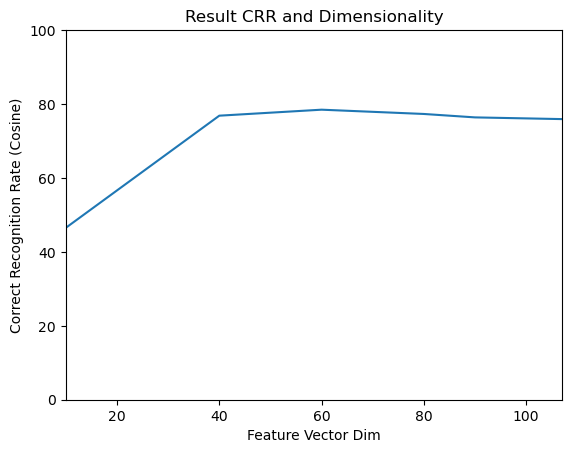

ROC Metrics : 

Threshold         0.400000
false_positive    0.015504
true_positive     0.663366
Name: 0, dtype: float64 

Threshold         0.500000
false_positive    0.022124
true_positive     0.519417
Name: 1, dtype: float64 

Threshold         0.600000
false_positive    0.114286
true_positive     0.219512
Name: 2, dtype: float64 



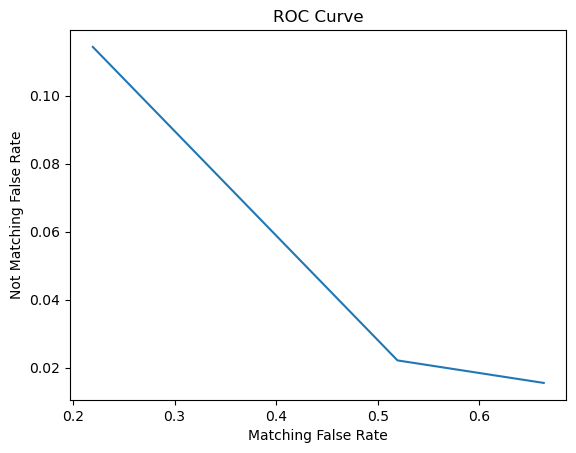

In [11]:
# Read training images from CASIA dataset
training_images = [cv2.imread(file) for file in sorted(glob.glob('CASIA Iris Image Database (version 1.0)/*/1/*.bmp'))]

# Run localization, normalization, enhancement, and feature extraction on training images
boundary, centers = localize_iris(training_images)
normalized = normalize_iris(boundary, centers)
enhanced = enhance_images(normalized)
training_feature_vector = feature_extraction(enhanced)
print("Training complete.")


# Read testing images from CASIA dataset
testing_images = [cv2.imread(file) for file in sorted(glob.glob('CASIA Iris Image Database (version 1.0)/*/2/*.bmp'))]

# Run localization, normalization, enhancement, and feature extraction on testing images
boundary_1, centers_1 = localize_iris(testing_images)
normalized_1 = normalize_iris(boundary_1, centers_1)
enhanced_1 = enhance_images(normalized_1)
testing_feature_vector = feature_extraction(enhanced_1)
print("Testing complete.")


# Define lists to store CRR scores and matching results
recognition_L1 = []
recognition_L2 = []
recognition_cosine = []
matching_cosine = []
matching_cosine_ROC = []

# Perform matching and calculate CRR scores for various dimensionalities
components = [10, 40, 60, 80, 90, 107]

print("Beginning matching testing with training data...")
for component in components:
    # Run matching for current dimensionality
    component_matching_L1, component_matching_L2, component_matching_cosine, component_matching_cosine_ROC = matching_iris(training_feature_vector, testing_feature_vector, component, 0)

    # Calculate CRR scores for current dimensionality
    component_recognition_L1, component_recognition_L2, component_recognition_cosine = performance_evaluation(component_matching_L1, component_matching_L2, component_matching_cosine)

    # Append results to lists
    recognition_L1.append(component_recognition_L1)
    recognition_L2.append(component_recognition_L2)
    recognition_cosine.append(component_recognition_cosine)
    matching_cosine.append(component_matching_cosine)
    matching_cosine_ROC.append(component_matching_cosine_ROC)

# Perform matching and calculate CRR scores for original feature vector
true_matching_L1, true_matching_L2, true_matching_cosine, true_matching_cosine_ROC = matching_iris(training_feature_vector, testing_feature_vector, 0, 1)
true_recognition_L1, true_recognition_L2, true_recognition_cosine = performance_evaluation(true_matching_L1, true_matching_L2, true_matching_cosine)

print("Matching complete.", "\n")


# Orginal and reduced feature set Table for CRR rates
print("\n")
dict = {'Similarity Metrics':['L1','L2','Cosine Distance'],'CRR for Original Feature Set':[true_recognition_L1, true_recognition_L2, true_recognition_cosine],'CRR for Reduced Feature Set (107)':[recognition_L1[5],recognition_L2[5],recognition_cosine[5]]}
dictionary = pd.DataFrame(dict)
print("Comparative Analysis of Recognition Results Using Various Similarity Metrics : \n")
print(dictionary.iloc[0],"\n")
print(dictionary.iloc[1],"\n")
print(dictionary.iloc[2],"\n")


#Visualizing the Increasing Cosine Similarity-Dimensionality Relationship 
plt.plot(components, recognition_cosine)
plt.axis([10, 107, 0, 100])
plt.ylabel("Correct Recognition Rate (Cosine)")
plt.xlabel("Feature Vector Dim")
plt.title("Result CRR and Dimensionality")
plt.show()

# false positive and true positive rates
false_positive_rates = []
true_positive_rates = []

thresholds = [0.4, 0.5, 0.6]

for a in range(0, 3):
    acceptance_false=0
    rejection_false=0
    num_1 = len([i for i in matching_cosine_ROC[5][a] if i == 1])
    num_0 = len([i for i in matching_cosine_ROC[5][a] if i == 0])

    for b in range(0,len(matching_cosine[5])):
        if matching_cosine[5][b] == 0 and matching_cosine_ROC[5][a][b] == 1:
            acceptance_false += 1
        if matching_cosine[5][b] == 1 and matching_cosine_ROC[5][a][b] == 0:
            rejection_false += 1
    
    false_positive = acceptance_false / num_1
    true_positive = rejection_false / num_0

    threshold=[0.4,0.5,0.6]
    false_positive_rates.append(false_positive)
    true_positive_rates.append(true_positive)

roc_dictionary = pd.DataFrame({"Threshold": threshold, "false_positive": false_positive_rates, "true_positive": true_positive_rates})
print("ROC Metrics : \n")
print(roc_dictionary.iloc[0], "\n")
print(roc_dictionary.iloc[1], "\n")
print(roc_dictionary.iloc[2], "\n")

# Plotting the ROC Curve
plt.plot(true_positive_rates, false_positive_rates)
plt.title("ROC Curve")
plt.ylabel("Not Matching False Rate")
plt.xlabel("Matching False Rate")
plt.show()